In [1]:
## Imports
%matplotlib inline
import pandas as pd
import numpy as np
import math
import seaborn as sns; sns.set(color_codes=True)
import matplotlib.pyplot as plt
import operator

In [2]:
## Read data from source
file = 'data.xlsx'
df = pd.read_excel(file, header=None)
nr_rows = df.shape[0]
nr_cols = df.shape[1]

In [3]:
## Convert Y feature to number
def numberize(value): 
    return 1 if value == 'M' else 0

df[0] = df[0].apply(lambda x: numberize(x))

    
## Normalize data
def norm(vector):
    min = np.amin(vector)
    max = np.amax(vector)
    return (vector - min) / (min - max )

for i in range(nr_cols):
    df[:][i] = norm(df[:][i])    

In [4]:
## Split X and Y
X = df.ix[:,1:]
Y = df.ix[:,0]


In [5]:
## Add '1' - Feature
ones = np.ones(nr_rows, dtype=np.int)
X.insert(0, '', ones)
X.columns = range(df.shape[1])
X.head()


,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,1,-0.521037,-0.022658,-0.545989,-0.363733,-0.593753,-0.792037,-0.703140,-0.731113,-0.686364,...,-0.620776,-0.141525,-0.668310,-0.450698,-0.601136,-0.619292,-0.568610,-0.912027,-0.598462,-0.418864
1,1,-0.643144,-0.272574,-0.615783,-0.501591,-0.289880,-0.181768,-0.203608,-0.348757,-0.379798,...,-0.606901,-0.303571,-0.539818,-0.435214,-0.347553,-0.154563,-0.192971,-0.639175,-0.233590,-0.222878
2,1,-0.601496,-0.390260,-0.595743,-0.449417,-0.514309,-0.431017,-0.462512,-0.635686,-0.509596,...,-0.556386,-0.360075,-0.508442,-0.374508,-0.483590,-0.385375,-0.359744,-0.835052,-0.403706,-0.213433
3,1,-0.210090,-0.360839,-0.233501,-0.102906,-0.811321,-0.811361,-0.565604,-0.522863,-0.776263,...,-0.248310,-0.385928,-0.241347,-0.094008,-0.915472,-0.814012,-0.548642,-0.884880,-1.000000,-0.773711
4,1,-0.629893,-0.156578,-0.630986,-0.489290,-0.430351,-0.347893,-0.463918,-0.518390,-0.378283,...,-0.519744,-0.123934,-0.506948,-0.341575,-0.437364,-0.172415,-0.319489,-0.558419,-0.157500,-0.142595


In [6]:
## Prepare training set and testing datasets

In [7]:
X_train = X.head(300)
Y_train = Y.head(300)

In [8]:
nr_test_rows = nr_rows - 300
X_test = X.tail(nr_test_rows)
Y_test = Y.tail(nr_test_rows)

In [9]:
## Define helper methods

def sig(z):
    return 1 / (1 + math.e ** (-1*z))

def gradient_descent(X, Y, alpha=0.1, max_iterations=100):
    predictions = []
    Theta = np.zeros(X.shape[1], dtype=np.int)  # Starting Theta
    
    while (max_iterations > 0):
        prediction = sig(np.dot(X,Theta))
        Theta = Theta + (alpha * (Y - prediction) * prediction * (1 - prediction)).dot(X)
        predictions.append(prediction)
        max_iterations -= 1
    
    return [predictions, Theta]

# Transform p values to 1's and 0's
crisp_predictor = lambda x: 1 if x >= 0.5 else 0 

def accuracy(crisp, Y): # Subtract predictions from the real values and count the 1's
    difference = pd.Series(crisp - Y)
    correct_predictions = (difference == 0).sum()
    total_predictions = crisp.shape[0]

    return (correct_predictions / total_predictions * 100)

def quality_test(Theta, X, Y):
    predictions = sig(np.dot(X,Theta))
    crisp = pd.Series(predictions).apply(crisp_predictor)
    quality = accuracy(crisp, Y)
    return quality

In [10]:
## Run predictions by iterations of the algorithm
def quality_by_iteration(alpha, max_iterations):
    predictions_by_iteration = gradient_descent(X_train, Y_train, alpha, max_iterations)[0]
    
    
    qualities = []
    for prediction in predictions_by_iteration:
        crisp = pd.Series(prediction).apply(crisp_predictor)
        quality = accuracy(crisp, Y_train)
        qualities.append(quality)

    return qualities    

In [11]:
## MAIN Exercise = Select 5 best features
alpha = 0.03
max_iterations = 1000
qualities = pd.Series(quality_by_iteration(alpha, max_iterations))  

def test_accuracy(X_train, Y_train, X_test, Y_test):
    final_theta = predictions_by_iteration = gradient_descent(X_train, Y_train, alpha, max_iterations)[1]
    predictions = sig(np.dot(X_test,final_theta))
    crisp = pd.Series(predictions).apply(crisp_predictor)
    return accuracy(crisp, Y_test.values)
    

def find_best_features(X_train, Y_train, X_test, Y_test, max_features=5):
    all_features = np.asarray(X_train.columns.values)
    iterating_over = [0]
    features_added = 0
    for_comparison = { 'Nr of Features': [], 'Accuracy': []}
    
    while (features_added < max_features):
        print("Adding feature nr ", features_added + 1)
        accuracy_with_added_feature = {}    
        for feature in all_features:
            with_added_feature = list(iterating_over)
            
            # Add feature to dataset for iteration
            if feature in with_added_feature:
                # print("feature already in dataset", feature)
                continue
            with_added_feature.append(feature) 
            new_X_train = X_train[with_added_feature]
            new_X_test = X_test[with_added_feature]

            calculated_accuracy = test_accuracy(new_X_train, Y_train, new_X_test, Y_test)
            accuracy_with_added_feature[feature] = calculated_accuracy
        
        features_added += 1
   
        best_feature_to_add = max(accuracy_with_added_feature.items(), key=operator.itemgetter(1))[0]
        #print(f"Addiing feature # {best_feature_to_add} with added accuracy of {accuracy_with_added_feature[best_feature_to_add]}.")
        iterating_over.append(best_feature_to_add)
        
        for_comparison['Nr of Features'].append(features_added)
        for_comparison['Accuracy'].append(accuracy_with_added_feature[best_feature_to_add])

    print(f"Finished finding {features_added} best features...")    
    return(for_comparison)

In [12]:
accuracies_by_nr_of_features = find_best_features(X_train, Y_train, X_test, Y_test)

Adding feature nr  1
Adding feature nr  2
Adding feature nr  3
Adding feature nr  4
Adding feature nr  5
Finished finding 5 best features...


In [13]:
accuracies_by_nr_of_features['Nr of Features'].append(31)
accuracies_by_nr_of_features['Accuracy'].append(97.77)
accuracies_by_nr_of_features

{'Accuracy': [92.193308550185876,
  95.167286245353154,
  96.282527881040892,
  96.6542750929368,
  97.026022304832722,
  97.77],
 'Nr of Features': [1, 2, 3, 4, 5, 31]}

In [14]:
df = pd.DataFrame(accuracies_by_nr_of_features)

In [15]:
plt.figure();

(90, 100)

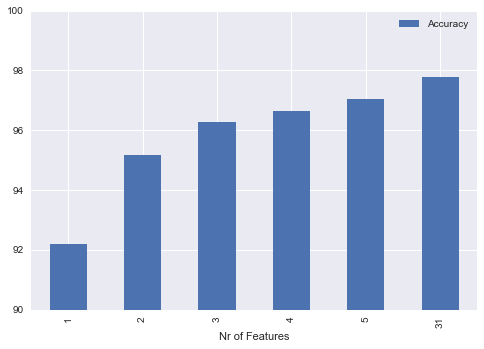

In [16]:
ax = df.plot(x='Nr of Features', y='Accuracy', kind='bar')
ax.set_ylim(90,100)
